### 2. Data preprocessing

#### 2.1 Feature extraction

Feature extraction is done using the Named Entity Recognition module of the SpaCy library. The raw data is of the following form:

| ID    | Patient_ID | Name | Ethnicity | Age | Location | Total PSA | Clinically Significant | PI-RAD | MRI Date | Tumor Marker Results | Conclusions | Anonymized
| -------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| 0 | | | Hispanic | 53 | | 4.1 | Yes | 2 | 2023-12-01 | Low | WE SUGGEST TO DISCARD MALIGNANCY. | Yes
| 1 | | | Black | 47 | | 5.73 | Yes | 3 | 2024-02-21 | Moderate | WE SUGGEST TO FOLLOW UP WITH MR. PARKER IN 6 MONTHS. | No
| 2 | PRO00000002| Jonathan Parker | White | 69 | "4366 Victor Path Suite 246, Russelltown, CO 80748"| 24.41 | Yes | 5 | 2024-03-17 | High | POSSIBLE MALIGNANCY. BIOPSY RECOMMENDED. | No

The goal is to extract the following features: 
  - Presence of the patient_id, name or location fields
  - Mention of patient_id, name or location in the conclusions section

The output table (data frame) has the following structure:

| ID    | Ner_Output | Label
| -------- | ------- | ------- |
| 0 | 0 | 0 |
| 1 | 1 | 1 |
| 2 | 0 | 1 |


#### Imports and Spark session initialization

In [3]:
import re
import spacy
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType, IntegerType, BooleanType
from pyspark.sql.functions import when

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [14]:
spark = init_spark()
broadcasted_nlp = spark.sparkContext.broadcast(spacy.load("en_core_web_sm"))

def is_anonymized(text):
    nlp = broadcasted_nlp.value 
    doc = nlp(text)

    entities = set(ent.label_ for ent in doc.ents) 

    contains_ne = ('GPE' in entities) or ('PERSON' in entities) or ('ORG' in entities)
    pattern = r'PRO\d{8}'
    contains_id = re.search(pattern, text) is not None

    return 0 if (contains_ne or contains_id) else 1

def replace_null_with_zero(value):
    return 0 if value is None else 1


print(is_anonymized('WE SUGGEST TO FOLLOW UP WITH MR. PARKER IN 6 MONTHS.'))
print(is_anonymized('Results match MGH conclusions.'))
print(is_anonymized('We suggest to discard malignancy.'))
print(is_anonymized('Possible malignancy. Biopsy recommended.'))

print()

print(is_anonymized('We suggest to follow up with patient PRO00000002 in 6 months.'))
print(is_anonymized('We suggest to follow up with patient PRO00000322 in 6 months.'))
print(is_anonymized('We suggest to follow up with patient PRO00002 in 6 months.'))
print(is_anonymized('We suggest to follow up with the patient in 6 months.'))


0
0
1
1

0
0
1
1


In [15]:
filename = 'new_data.csv'
df = spark.read.csv(filename, header=True)

#UDFs to generate relevant features
ner_udf = udf(is_anonymized, returnType=IntegerType())
replace_null_with_zero_udf = udf(replace_null_with_zero, IntegerType())

#Adding feature columns to data frame
def map_label(label):
    return when(label == "Yes", 1).otherwise(0)

df = df.withColumn("Ner_Output", ner_udf("Conclusions"))\
       .withColumn("Anonimized", map_label(df["Anonimized"]))

#Dropping useless features
columns_to_drop = ["ID", "Patient ID", "Name", "Location", "Ethnicity", "Age", "Total PSA (ng/ml)", "Clinically Significant", "PI-RAD", "MRI Date", "Tumor Marker Results", "Conclusions"]
df = df.drop(*columns_to_drop)

print(df.show())
df.toPandas().to_csv('featured_data.csv')

+-----------+----------+----------+
| Patient ID|Anonimized|Ner_Output|
+-----------+----------+----------+
|PRO00000000|         0|         0|
|PRO00000001|         0|         1|
|PRO00000002|         0|         0|
|PRO00000003|         0|         0|
|PRO00000004|         0|         1|
|PRO00000005|         0|         1|
|PRO00000006|         0|         0|
|PRO00000007|         0|         1|
|PRO00000008|         0|         0|
|PRO00000009|         0|         0|
|PRO00000010|         0|         1|
|PRO00000011|         0|         0|
|PRO00000012|         0|         0|
|       NULL|         0|         1|
|PRO00000014|         0|         0|
|PRO00000015|         0|         0|
|       NULL|         0|         0|
|       NULL|         0|         0|
|PRO00000018|         0|         0|
|PRO00000019|         0|         1|
+-----------+----------+----------+
only showing top 20 rows

None


In [37]:
spark_df = spark.createDataFrame(df)
spark_df = spark_df.drop("Patient ID")
spark_df.show()
spark_df.toPandas().to_csv('processed_data.csv')

+----------+----------+
|Anonimized|Ner_Output|
+----------+----------+
|         0|         0|
|         0|         1|
|         0|         0|
|         0|         0|
|         0|         1|
|         0|         1|
|         0|         0|
|         0|         1|
|         0|         0|
|         0|         0|
|         0|         1|
|         0|         0|
|         0|         0|
|         0|         1|
|         0|         0|
|         0|         0|
|         0|         0|
|         0|         0|
|         0|         0|
|         0|         1|
+----------+----------+
only showing top 20 rows



### Random Forest

In [38]:
from pyspark import SparkFiles
# from pyspark.sql import SparkSession
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import StringIndexer, VectorAssembler
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()

In [43]:
df = pd.read_csv("processed_data.csv",index_col=0)
df.head()

x = df.drop('Anonimized', axis=1)
y = df['Anonimized']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)


In [44]:
param_dist = {'n_estimators': randint(1,20),
              'max_depth': randint(1,5)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x29fcb9c10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x29fcba690>})

In [45]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

Best hyperparameters: {'max_depth': 1, 'n_estimators': 1}


Accuracy: 0.9665
Precision: 0.0
Recall: 0.0


/Users/linaismail/Documents/Concordia/SOEN471/ProvistaAI/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


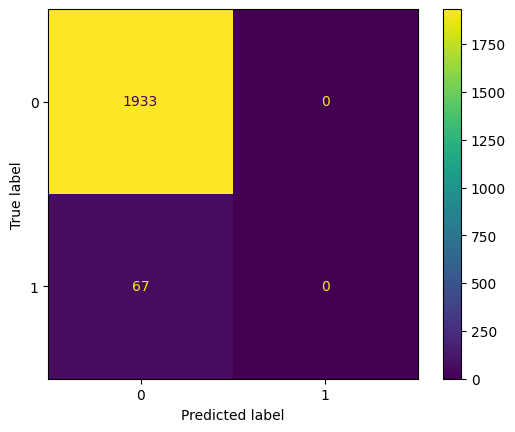

In [47]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

### KNN

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

In [50]:

# x = df.drop('Anonymized', axis=1)
# y = df['Anonymized']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)



Text(0, 0.5, 'Accuracy Score')

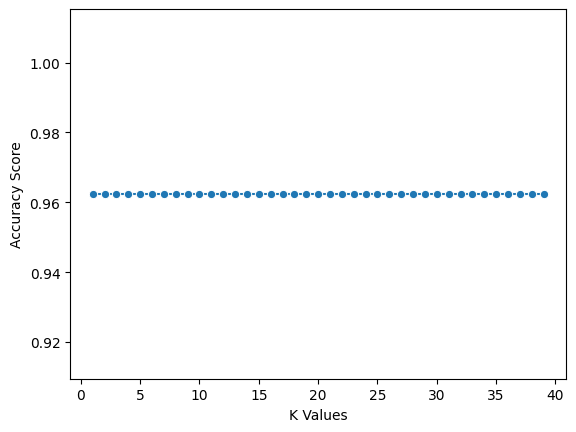

In [51]:
k_values = [i for i in range (1,40)]
scores = []

scaler = StandardScaler()
x = scaler.fit_transform(x)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x, y, cv=4)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [52]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
print("Best k: ", best_k)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Best k:  1


Accuracy: 0.9665
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/linaismail/Documents/Concordia/SOEN471/ProvistaAI/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

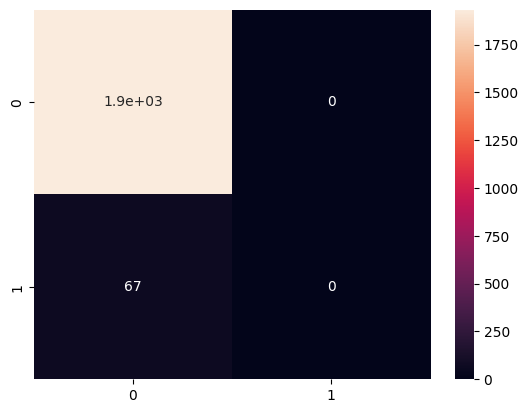

In [53]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

sns.heatmap(conf_matrix, annot=True)